# Load packages

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Seurat)
    library(CCA)
    library(singlecellmethods)
})

select <- dplyr::select

# set figure size
fig.size <- function(height = 4, width = 4){
    options(repr.plot.height = height, repr.plot.width = width)
}

# get the most frequently occurring string
charMode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

# designate directory with your pseudobulk and bulk data
dir <- getwd()

# CCA on AMP and R4RA

## Load bulk data  and get intersecting genes

In [2]:
system.time({
    # Load data from directory
    collapsed_counts <- readRDS(paste0(dir, '/amp_pseudobulk_03-13-23.rds'))
    pseudo_amp_counts <- collapsed_counts$counts_mat
    colnames(pseudo_amp_counts) <- collapsed_counts$meta_data$sample
    amp_meta <- collapsed_counts$meta_data
})

collapsed_counts %>% str(1)

   user  system elapsed 
  0.102   0.005   0.107 

List of 2
 $ counts_mat: num [1:30997, 1:70] 0 0 36 4 0 0 0 2 286 15 ...
  ..- attr(*, "dimnames")=List of 2
 $ meta_data :'data.frame':	70 obs. of  3 variables:


In [3]:
query_meta <- readRDS(paste0(dir, '/r4ra_meta.rds'))
query_counts <- readRDS(paste0(dir, '/r4ra_counts.rds'))
query_counts %>% dim
query_counts %>% head(2)
query_meta <- query_meta %>% filter(sample_id %in% colnames(query_counts))
query_meta %>% dim
query_meta %>% head(2)

[1] 24569   184

,R4RAPAT00002-week0,R4RAPAT00013-week0,R4RAPAT00094-week16,R4RAPAT00095-week0,R4RAPAT00096-week0,R4RAPAT00097-week0,R4RAPAT00097-week16,R4RAPAT00099-week0,R4RAPAT00099-week16,R4RAPAT00100-week0,⋯,R4RAPAT00084-week0,R4RAPAT00085-week0,R4RAPAT00089-week0,R4RAPAT00090-week0,R4RAPAT00091-week0,R4RAPAT00091-week16,R4RAPAT00092-week0,R4RAPAT00093-week0,R4RAPAT00093-week16,R4RAPAT00094-week0
MIR1302-2HG,2,0,6,2,1,3,1,1,3,2,⋯,8,0,0,2,1,0,0,1,1,1
FAM138A,1,1,4,4,1,6,1,17,1,3,⋯,6,0,0,0,0,5,0,0,4,1


[1] 184  79

,pred_CTAP,sample_name,ena_sample,biosd_sample,sample_id,organism,individual,tissue_part,disease,clinical_history,⋯,ena_run,fastq_url,sampling_time_point,unit_time_unit_2,term_source_ref_6,term_accession_number_6,entropy,CV1,CV2,treatment
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,T + B,Sample 1,ERS11589556,SAMEA13989176,R4RAPAT00002-week0,Homo sapiens,R4RAPAT00002,synovial tissue,rheumatoid arthritis,difficult to treat rheumatoid arthritis,⋯,ERR9539213,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/003/ERR9539213/ERR9539213_1.fastq.gz,0,week,EFO,UO_0000034,0.9502705,0.3378673,-0.1819778,Tocilizumab
2,M,Sample 10,ERS11589557,SAMEA13989177,R4RAPAT00013-week0,Homo sapiens,R4RAPAT00013,synovial tissue,rheumatoid arthritis,difficult to treat rheumatoid arthritis,⋯,ERR9539214,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/004/ERR9539214/ERR9539214_1.fastq.gz,0,week,EFO,UO_0000034,0.6730117,-0.6786075,0.1915172,Rituximab


In [4]:
# Filter out genes that are not expressed in every sample
system.time({
    obj_ref <- CreateSeuratObject(counts = pseudo_amp_counts, min.cells = ncol(pseudo_amp_counts))
    obj_query <- CreateSeuratObject(counts = query_counts, min.cells = ncol(query_counts))
})

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


   user  system elapsed 
  0.884   0.047   0.931 

In [5]:
obj_ref
obj_query

An object of class Seurat 
13216 features across 70 samples within 1 assay 
Active assay: RNA (13216 features, 0 variable features)

An object of class Seurat 
15107 features across 184 samples within 1 assay 
Active assay: RNA (15107 features, 0 variable features)

In [6]:
inter_genes <- intersect(rownames(obj_ref), rownames(obj_query))
inter_genes <- intersect(inter_genes, rownames(query_counts))
inter_genes %>% length

[1] 11843

In [7]:
# Subset count matrices by intersecting genes
test_ref <- pseudo_amp_counts[inter_genes, ] %>% data.matrix
test_ref %>% dim
test_ref %>% head(2)

test_query <- query_counts[inter_genes, ] %>% data.matrix
test_query %>% dim
test_query %>% head(2)

[1] 11843    70

,BRI-401,BRI-403,BRI-405,BRI-407,BRI-409,BRI-411,BRI-413,BRI-415,BRI-417,BRI-419,⋯,BRI-613,BRI-615,BRI-617,BRI-619,BRI-621,BRI-623,BRI-625,BRI-627,BRI-631,BRI-635
LINC00115,183,226,105,143,144,116,203,319,130,237,⋯,106,298,160,192,24,269,167,69,72,389
NOC2L,1430,1309,421,1124,1101,1003,1362,2151,585,1756,⋯,1162,2629,1029,1882,257,2028,1061,671,805,1740


[1] 11843   184

,R4RAPAT00002-week0,R4RAPAT00013-week0,R4RAPAT00094-week16,R4RAPAT00095-week0,R4RAPAT00096-week0,R4RAPAT00097-week0,R4RAPAT00097-week16,R4RAPAT00099-week0,R4RAPAT00099-week16,R4RAPAT00100-week0,⋯,R4RAPAT00084-week0,R4RAPAT00085-week0,R4RAPAT00089-week0,R4RAPAT00090-week0,R4RAPAT00091-week0,R4RAPAT00091-week16,R4RAPAT00092-week0,R4RAPAT00093-week0,R4RAPAT00093-week16,R4RAPAT00094-week0
LINC00115,15,58,51,43,35,47,89,109,87,108,⋯,44,55,32,56,43,95,78,76,56,72
NOC2L,2110,1499,2047,1278,1229,1311,1889,1215,1791,2120,⋯,1617,1400,1214,1753,1973,2178,2377,2022,1436,2478


## Make new SeuratObjs and normalize/HVG

In [8]:
system.time({
    obj_ref <- CreateSeuratObject(counts = test_ref, min.cells = ncol(test_ref))
    obj_query <- CreateSeuratObject(counts = test_query, min.cells = ncol(test_query))
})

   user  system elapsed 
  0.136   0.019   0.155 

In [9]:
obj_ref
obj_query

An object of class Seurat 
11843 features across 70 samples within 1 assay 
Active assay: RNA (11843 features, 0 variable features)

An object of class Seurat 
11843 features across 184 samples within 1 assay 
Active assay: RNA (11843 features, 0 variable features)

In [10]:
# Scale factor may need to change based on singularity problems during matrix decomposition in CCA
scale.factor <- 1e7
system.time({
    obj_ref <- NormalizeData(obj_ref, normalization.method = 'LogNormalize', scale.factor = scale.factor)
    obj_query <- NormalizeData(obj_query, normalization.method = 'LogNormalize', scale.factor = scale.factor)
})

   user  system elapsed 
  0.167   0.000   0.169 

In [11]:
# Number of features may need to change based on singularity problems during matrix decomposition in CCA
nfeatures <- 4500
system.time({
    obj_ref <- FindVariableFeatures(obj_ref, selection.method = 'vst', nfeatures = nfeatures)
    obj_query <- FindVariableFeatures(obj_query, selection.method = 'vst', nfeatures = nfeatures)
})

obj_ref
obj_query

   user  system elapsed 
  0.721   0.001   0.723 

An object of class Seurat 
11843 features across 70 samples within 1 assay 
Active assay: RNA (11843 features, 4500 variable features)

An object of class Seurat 
11843 features across 184 samples within 1 assay 
Active assay: RNA (11843 features, 4500 variable features)

In [12]:
vargenes_ref <- VariableFeatures(obj_ref)
vargenes_ref %>% str

vargenes_query <- VariableFeatures(obj_query)
vargenes_query %>% str

# Find the intersection of variable genes between the 2 datasets
tot_vargenes <- intersect(vargenes_ref, vargenes_query)
tot_vargenes %>% str

 chr [1:4500] "DIRC3" "PI16" "ITGA11" "SCRG1" "IGKC" "HK2" "CLIC5" "PTGIS" ...
 chr [1:4500] "DERL3" "FOSB" "DIRC3" "NR4A1" "IL6" "C15orf48" "LMOD3" ...
 chr [1:2849] "DIRC3" "PI16" "ITGA11" "SCRG1" "IGKC" "HK2" "CLIC5" "PTGIS" ...


In [13]:
system.time({
    norm_ref <- GetAssayData(obj_ref, slot = 'data')[tot_vargenes, ] %>% data.matrix
    norm_query <- GetAssayData(obj_query, slot = 'data')[tot_vargenes, ] %>% data.matrix
})

norm_ref %>% head(2)
norm_query %>% head(2)

   user  system elapsed 
  0.064   0.000   0.063 

,BRI-401,BRI-403,BRI-405,BRI-407,BRI-409,BRI-411,BRI-413,BRI-415,BRI-417,BRI-419,⋯,BRI-613,BRI-615,BRI-617,BRI-619,BRI-621,BRI-623,BRI-625,BRI-627,BRI-631,BRI-635
DIRC3,3.573715,2.7632521,4.276253,2.722215,3.059241,4.492326,7.109720,5.869457,3.457996,1.962448,⋯,1.364241,3.924999,2.061656,4.791429,0.9586509,2.954588,2.814404,4.1071741,2.826548,7.439555
PI16,1.593027,0.9669921,2.052643,2.900059,3.042379,2.776087,1.569742,2.744847,5.695071,1.637751,⋯,2.445014,3.060934,3.246191,5.894498,4.2506578,5.575118,7.337359,0.6912682,3.504222,7.208280


,R4RAPAT00002-week0,R4RAPAT00013-week0,R4RAPAT00094-week16,R4RAPAT00095-week0,R4RAPAT00096-week0,R4RAPAT00097-week0,R4RAPAT00097-week16,R4RAPAT00099-week0,R4RAPAT00099-week16,R4RAPAT00100-week0,⋯,R4RAPAT00084-week0,R4RAPAT00085-week0,R4RAPAT00089-week0,R4RAPAT00090-week0,R4RAPAT00091-week0,R4RAPAT00091-week16,R4RAPAT00092-week0,R4RAPAT00093-week0,R4RAPAT00093-week16,R4RAPAT00094-week0
DIRC3,2.240145,4.598112,4.431832,3.782860,2.532417,4.974406,4.049793,3.152802,3.314965,4.452349,⋯,4.250683,4.838167,2.596675,4.649755,2.649286,4.089174,4.287927,5.539843,3.404072,4.500684
PI16,5.907670,2.290551,4.469131,4.150416,4.953441,4.557792,5.993448,4.592040,3.359146,5.318301,⋯,7.402387,2.795243,2.954131,4.456580,4.622717,3.157885,1.895331,2.330146,4.677082,5.781371


In [14]:
system.time({
    scaled_ref <- norm_ref %>% scaleData
    scaled_query <- norm_query %>% scaleData
    
    scaled_ref <- scaled_ref[!rowSums(!is.finite(scaled_ref)), ]
    scaled_query <- scaled_query[!rowSums(!is.finite(scaled_query)), ]
    
    gene <- intersect(scaled_ref %>% rownames, scaled_query %>% rownames)
    
    scaled_ref <- scaled_ref[gene, ]
    scaled_query <- scaled_query[gene, ]
})

scaled_ref %>% dim
scaled_query %>% dim

scaled_ref %>% head(2)

   user  system elapsed 
  0.022   0.000   0.023 

[1] 2849   70

[1] 2849  184

,BRI-401,BRI-403,BRI-405,BRI-407,BRI-409,BRI-411,BRI-413,BRI-415,BRI-417,BRI-419,⋯,BRI-613,BRI-615,BRI-617,BRI-619,BRI-621,BRI-623,BRI-625,BRI-627,BRI-631,BRI-635
DIRC3,0.05068252,-0.5163013,0.5421638,-0.5450103,-0.3092332,0.6933235,2.524399,1.6567365,-0.03027244,-1.076528,⋯,-1.4950211,0.2964331,-1.0071237,0.9025702,-1.7787636,-0.3824462,-0.4805166,0.4238794,-0.47202086,2.755145
PI16,-1.03410769,-1.3659766,-0.7904592,-0.3412334,-0.2657878,-0.4069527,-1.046451,-0.4235135,1.14043751,-1.010399,⋯,-0.5824584,-0.2559515,-0.1577444,1.2461560,0.3747358,1.0768485,2.0110350,-1.5121413,-0.02095936,1.942608


# Perform CCA and get loadings

In [15]:
system.time({
    res <- cc(scaled_ref, scaled_query)
})

   user  system elapsed 
  8.351   6.424   3.567 

In [16]:
res %>% str(1)
res$cor %>% head

loadings <- res$scores
loadings %>% str(1)

res_cor <- data.frame(cor = res$cor, cc = paste0('CV', seq(res$cor %>% length)))
res_cor$cc <- factor(res_cor$cc, levels = gtools::mixedsort(res_cor$cc))
res_cor %>% dim

List of 5
 $ cor   : num [1:70] 0.966 0.945 0.915 0.875 0.858 ...
 $ names :List of 3
 $ xcoef : num [1:70, 1:70] -0.132 -0.195 -0.164 -0.206 -0.163 ...
  ..- attr(*, "dimnames")=List of 2
 $ ycoef : num [1:184, 1:70] -0.155 -0.212 -0.144 -0.14 -0.158 ...
  ..- attr(*, "dimnames")=List of 2
 $ scores:List of 6


[1] 0.9660443 0.9452748 0.9145554 0.8745857 0.8577825 0.8544877

List of 6
 $ xscores       : num [1:2849, 1:70] -0.254 0.535 1.18 0.874 -0.944 ...
  ..- attr(*, "dimnames")=List of 2
 $ yscores       : num [1:2849, 1:70] -0.315 0.617 1.257 0.814 -0.915 ...
  ..- attr(*, "dimnames")=List of 2
 $ corr.X.xscores: num [1:70, 1:70] -0.375 -0.688 0.325 -0.764 -0.409 ...
  ..- attr(*, "dimnames")=List of 2
 $ corr.Y.xscores: num [1:184, 1:70] 0.338 -0.679 0.186 0.564 0.152 ...
  ..- attr(*, "dimnames")=List of 2
 $ corr.X.yscores: num [1:70, 1:70] -0.363 -0.665 0.314 -0.738 -0.395 ...
  ..- attr(*, "dimnames")=List of 2
 $ corr.Y.yscores: num [1:184, 1:70] 0.35 -0.702 0.193 0.584 0.157 ...
  ..- attr(*, "dimnames")=List of 2


[1] 70  2

## Plot samples in CCA space

In [17]:
system.time({
    collapsed_counts <- readRDS('/data/srlab1/nmillard/SBG_Fibroblasts/amp_pseudobulk_5-16-22.rds')
    pseudo_amp_counts <- collapsed_counts$counts_mat
    colnames(pseudo_amp_counts) <- collapsed_counts$meta_data$sample
    amp_meta <- collapsed_counts$meta_data
})

amp_filt_meta <- readRDS("/data/srlab1/nmillard/spatial_projects/savedData/amp_full_meta_12-7-21.rds")
k <- amp_filt_meta %>% group_by(sample, CTAP = new_class, treatment) %>% summarize(N = n())
amp_meta <- merge(amp_meta, k[, c('sample','treatment')])

   user  system elapsed 
  0.081   0.003   0.087 

`summarise()` has grouped output by 'sample', 'CTAP'. You can override using the
`.groups` argument.


In [18]:
cor_xscores <- rbind.data.frame(loadings$corr.X.xscores, loadings$corr.Y.xscores)
colnames(cor_xscores) <- paste0('CV', seq(ncol(cor_xscores)))
plot_xscores <- cor_xscores
plot_xscores$dataset <- c(rep('AMP', nrow(loadings$corr.X.xscores)), rep('Query', nrow(loadings$corr.Y.xscores)))
plot_xscores$CTAP <- factor(c(amp_meta$CTAP, rep('Query', nrow(loadings$corr.Y.xscores))))
plot_xscores$treatment <- factor(c(amp_meta$treatment, rep('Query', nrow(loadings$corr.Y.xscores))))
plot_xscores %>% head(2)

,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10,⋯,CV64,CV65,CV66,CV67,CV68,CV69,CV70,dataset,CTAP,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
BRI-401,-0.3753469,0.4623112,-0.37769733,0.00536412,-0.15761981,0.2827367,-0.1159834,0.13335807,-0.02294406,0.05508501,⋯,0.026898543,-0.06360625,-0.04688510,0.04582637,0.01762735,-0.08533437,0.07386596,AMP,M,treatment naive
BRI-403,-0.6881127,0.2887142,-0.04928705,0.29785032,-0.06777742,0.1394904,-0.2703279,0.04030619,-0.05739699,-0.05089110,⋯,0.003815842,0.04585221,-0.02507922,-0.04354459,-0.03550825,-0.07593697,0.05242889,AMP,M,methotrexate failure


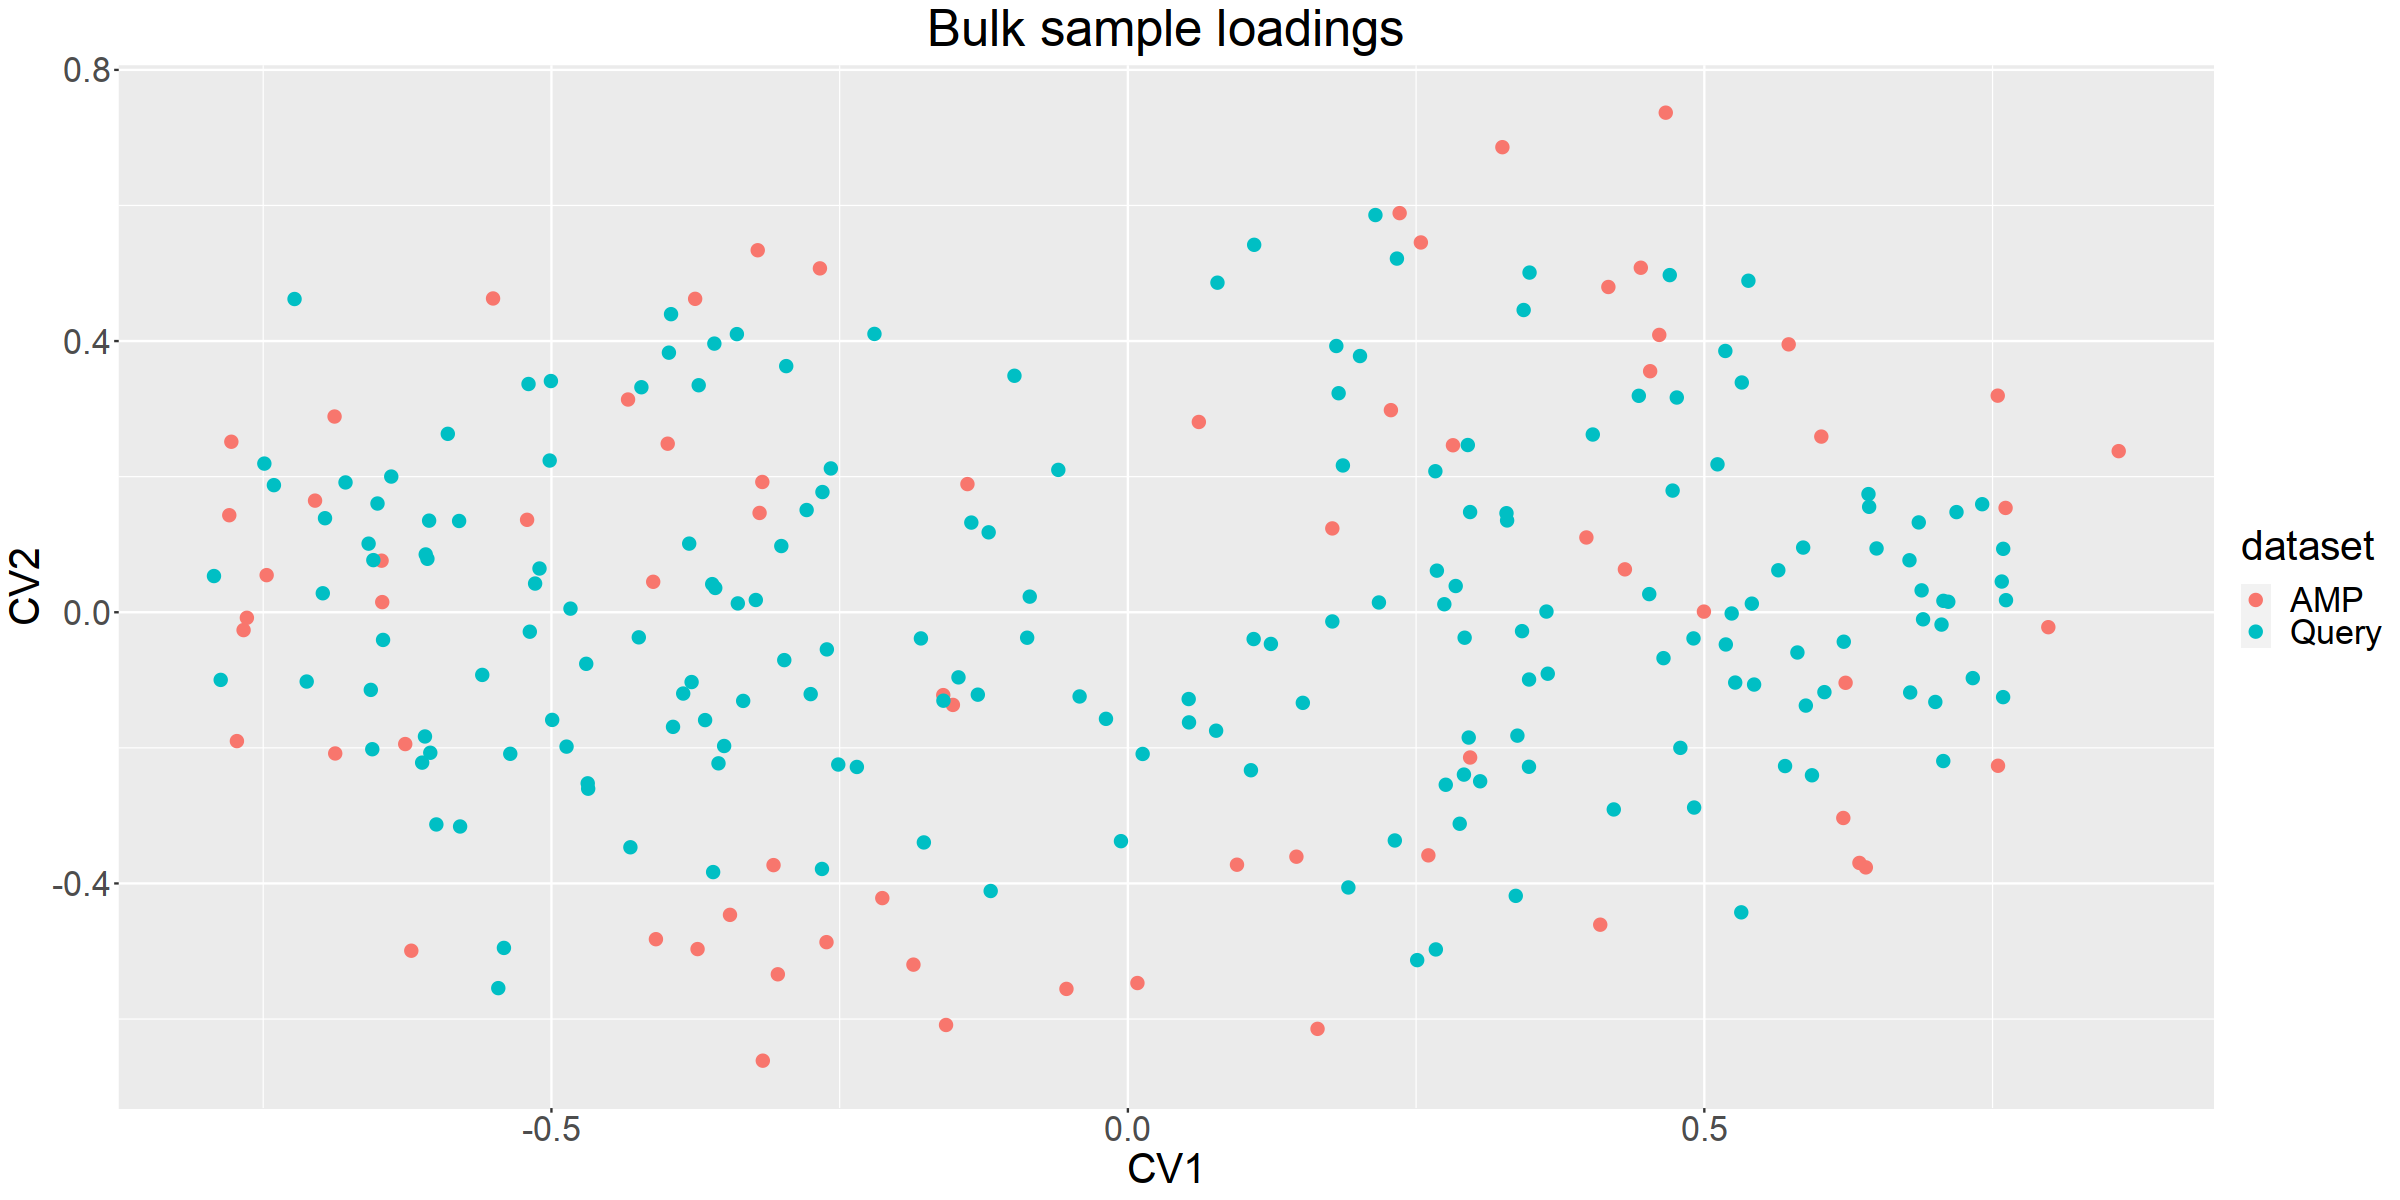

In [19]:
fig.size(10,20)
plot_xscores %>% ggplot(aes(x = CV1, y = CV2, col = dataset, label = rownames(cor_xscores))) +
    geom_point(size = 3) +
    labs(title = 'Bulk sample loadings') +
    theme(plot.title = element_text(size = 30, hjust = 0.5),
          legend.title = element_text(size = 24), legend.text = element_text(size = 20),
          # axis.title.x = element_text(size = 24), axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
          axis.title.x = element_text(size = 24), axis.text.x = element_text(size = 20),
          axis.title.y = element_text(size = 24), axis.text.y = element_text(size = 20),
          strip.text = element_text(size = 24),  strip.background = element_blank()) 

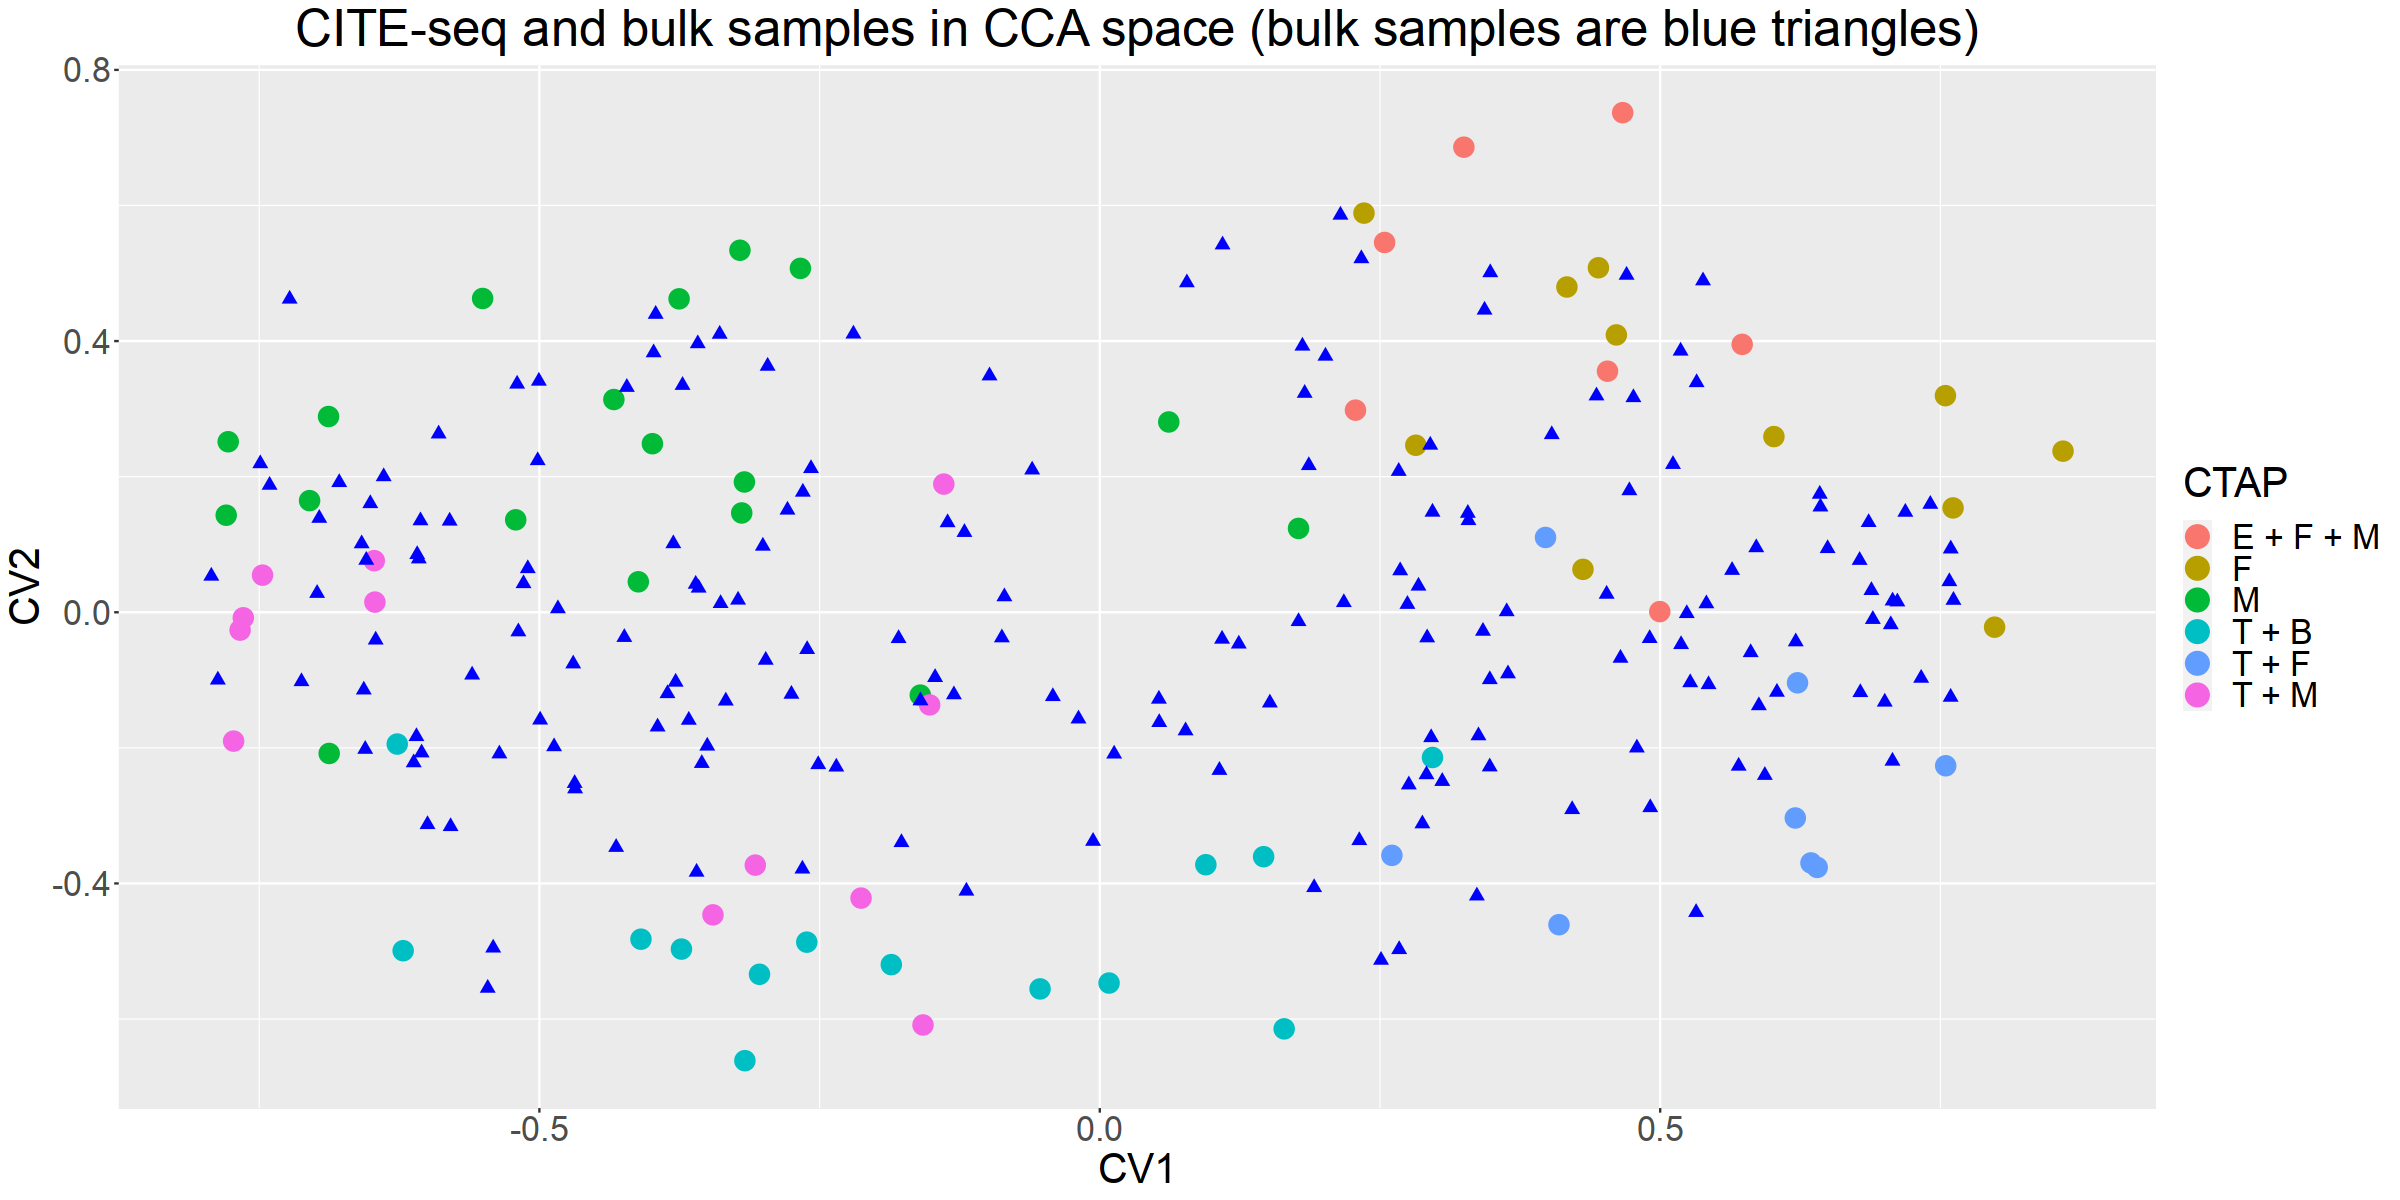

In [20]:
fig.size(10,20)
plot_xscores %>% 
    ggplot(aes(x = CV1, y = CV2, col = CTAP)) +
    geom_point(data = plot_xscores %>% filter(CTAP != 'Query'), size = 5) +
    labs(title = 'CITE-seq and bulk samples in CCA space (bulk samples are blue triangles)') +
    # scale_color_manual(values = testPal(plot_xscores$CTAP %>% unique %>% length)) +
    # scale_color_brewer(palette = 'Set1', drop = FALSE) +
    guides(color = guide_legend(override.aes = list(size = 6))) +
    geom_point(data = plot_xscores %>% filter(CTAP == 'Query'), size = 3, shape = 17, col = 'blue') +
    theme(plot.title = element_text(size = 30, hjust = 0.5),
          legend.title = element_text(size = 24), legend.text = element_text(size = 20),
          # axis.title.x = element_text(size = 24), axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
          axis.title.x = element_text(size = 24), axis.text.x = element_text(size = 20),
          axis.title.y = element_text(size = 24), axis.text.y = element_text(size = 20),
          strip.text = element_text(size = 24),  strip.background = element_blank())

# Predict CTAPs based on CC loadings

In [21]:
ref_ccs <- plot_xscores %>% filter(dataset == 'AMP') %>% select(-dataset)
query_ccs <- plot_xscores %>% filter(dataset == 'Query') %>% select(-dataset)
ref_ccs %>% head(2)
query_ccs %>% head(2)

,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10,⋯,CV63,CV64,CV65,CV66,CV67,CV68,CV69,CV70,CTAP,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
BRI-401,-0.3753469,0.4623112,-0.37769733,0.00536412,-0.15761981,0.2827367,-0.1159834,0.13335807,-0.02294406,0.05508501,⋯,0.04685834,0.026898543,-0.06360625,-0.04688510,0.04582637,0.01762735,-0.08533437,0.07386596,M,treatment naive
BRI-403,-0.6881127,0.2887142,-0.04928705,0.29785032,-0.06777742,0.1394904,-0.2703279,0.04030619,-0.05739699,-0.05089110,⋯,0.02568297,0.003815842,0.04585221,-0.02507922,-0.04354459,-0.03550825,-0.07593697,0.05242889,M,methotrexate failure


,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10,⋯,CV63,CV64,CV65,CV66,CV67,CV68,CV69,CV70,CTAP,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
R4RAPAT00002-week0,0.3378673,-0.1819778,-0.003211778,-0.1665734,-0.09194107,0.02218928,-0.03350496,0.09513804,-0.13454789,0.1487441,⋯,-0.001211599,-0.007378330,-0.024156484,-0.004728823,0.006635431,0.013346660,0.013376147,0.012468127,Query,Query
R4RAPAT00013-week0,-0.6786075,0.1915172,0.022409479,0.1891355,0.11394362,-0.08599967,-0.15399744,-0.04989546,0.02575358,0.1449398,⋯,0.003473283,0.001968791,0.009594042,0.005081604,-0.003222568,-0.001202237,0.002901435,0.002220757,Query,Query


In [22]:
# Number of CCs used for prediction is based on the amount of correlation the CCs account for. Decrease after 8 PCs
n_ccs <- 8
# k.param represents the number of neighbors (k.param - 1) used for predicting CTAP. k.param of 6 means that 5 neighbors are used
k.param <- 6

system.time({
    class_ccx <- list()
    # Loop through each bulk sample
    for(i in seq(nrow(query_ccs))){
        a <- rbind.data.frame(query_ccs[i, ], ref_ccs)
        a2 <- a[, seq(n_ccs)] %>% data.matrix
        # Find the nearest neighbors of a bulk sample
        b <- Seurat::FindNeighbors(object = a2, k.param = k.param, compute.SNN = FALSE, prune.SNN = 1/15, nn.eps = 0,
                                   nn.method = 'annoy', annoy.metric = 'euclidean', verbose = FALSE)
        # Retrieve the 5 nearest-neighbors
        d <- b[['nn']] %>% as.data.frame
        e <- which(d[1, ] == 1)

        f <-  data.frame(sample = colnames(d)[e[-1]])
        g <- merge(f, amp_meta)
        # Predict CTAP based on the 5-nearest neighbors 
        class_ccx[[i]] <- list(pred = charMode(g$CTAP), nn = g)
    }
    names(class_ccx) <- rownames(query_ccs)
})

   user  system elapsed 
  6.095   0.001   6.112 

In [31]:
# This dataframe will contain the predicted CTAPs
query_ctap_frame <- data.frame(sample_id = names(class_ccx),
                               pred_CTAP = map(class_ccx, 1) %>% unlist)
query_ctap_frame$pred_CTAP <- factor(query_ctap_frame$pred_CTAP,
                                     levels = c('T + B', 'T + M', 'M', 'T + F', 'E + F + M', 'F'))
query_ctap_frame %>% dim
query_ctap_frame %>% head(2)
query_ctap_frame$pred_CTAP %>% table

[1] 184   2

,sample_id,pred_CTAP
,<chr>,<fct>
R4RAPAT00002-week0,R4RAPAT00002-week0,T + B
R4RAPAT00013-week0,R4RAPAT00013-week0,M


.
    T + B     T + M         M     T + F E + F + M         F 
       53        27        39         5         9        51 

# End